# EEG Source Localization and SSVEP Analysis

This notebook provides a comprehensive pipeline for preprocessing EEG data, analyzing Steady-State Visual Evoked Potentials (SSVEP), and performing source localization. The pipeline is designed for reproducibility and modularity, allowing researchers to customize key parameters at each stage. The workflow is built on **MNE-Python**, integrating EEG signal processing techniques and advanced visualization methods.

#### Key Objectives
1. **Preprocess EEG Data**:
   - Load EEG data and apply bandpass filtering to isolate relevant frequency bands.
   - Detect and segment events into epochs for targeted analysis.
2. **SSVEP Analysis**:
   - Compute Power Spectral Density (PSD) for specific frequency bands.
   - Visualize the SSVEP response to 4 Hz and 6 Hz stimuli.
3. **Source Localization**:
   - Generate forward and inverse models for EEG source localization.
   - Map brain activations to specific regions of interest (ROI).
4. **Visualization**:
   - Create activation maps and movies for the selected ROI across different frequency bands.

#### Dependencies
- **MNE-Python**: For EEG data processing and source localization.
- **SciPy**: For signal processing tasks like PSD computation.
- **Matplotlib**: For visualizing SSVEP results.
- **ImageIO**: For saving activation movies.
- **FreeSurfer**: For anatomical modeling and source-space generation.

#### Workflow Outline
1. **EEG Preprocessing**: Load, filter, and epoch the EEG data.
2. **SSVEP Analysis**: Analyze the response to visual stimuli at specific frequencies.
3. **Source Localization**: Map the EEG signals to brain regions using forward and inverse models.
4. **Activation Movie Generation**: Visualize the source activations over time for selected ROIs.

This pipeline is ideal for analyzing steady-state responses and investigating neural activations related to visual stimuli.

### 1. EEG Preprocessing

This section focuses on the initial preprocessing of raw EEG data to prepare it for further analysis. The preprocessing pipeline includes:

1. **Loading EEG Data**: The raw EEG data is loaded from a file in BDF format using `MNE-Python`.
2. **Bandpass Filtering**: A bandpass filter is applied (default range: 1–40 Hz) to remove noise and isolate the frequency bands of interest, including those relevant to SSVEP (Steady-State Visual Evoked Potentials).
3. **Event Detection**: Events are extracted from the data to identify specific time points corresponding to stimuli or feedback.
4. **Epoching**: The continuous EEG signal is segmented into smaller time-locked epochs based on the detected events, with customizable start (`tmin`) and end (`tmax`) times.

The preprocessing step ensures that the EEG data is clean, segmented, and ready for subsequent source localization and analysis. Parameters such as the bandpass filter range and epoch time window are customizable to adapt to specific experimental needs.

In [1]:
import mne
import os

def preprocess_eeg(file_path, tmin=-0.2, tmax=1.5, bandpass=(1., 40.)):
    """
    Preprocess the EEG data: load, bandpass filter, and segment into epochs.
    
    Parameters:
        file_path (str): Path to the EEG data file in BDF format.
        tmin (float): The start time for the epochs in seconds (default is -0.2).
        tmax (float): The end time for the epochs in seconds (default is 1.5).
        bandpass (tuple): The frequency range for bandpass filtering (default is (1., 40.)).

    Returns:
        raw (Raw): The preprocessed raw EEG data.
        events (ndarray): Array of events detected in the EEG data.
        epochs (Epochs): The segmented EEG data based on events.
    """
    # Load EEG data
    raw = mne.io.read_raw_bdf(file_path, preload=True)
    
    # Bandpass filter (1–40 Hz for noise removal and SSVEP target range)
    raw.filter(bandpass[0], bandpass[1], fir_design='firwin')
    
    # Define events and epoch parameters
    events = mne.find_events(raw)
    event_id = {'4Hz': 1, '6Hz': 2, '4Hz_feedback': 11, '6Hz_feedback': 22}
    epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)
    
    return raw, events, epochs

# Preprocess the EEG data
raw, events, epochs = preprocess_eeg('datasets/EEG_Dataset/OT/OT_SSVEP_L.bdf')

Extracting EDF parameters from /Users/michaelzhou/Documents/GitHub/SilenceMap-Adaptation-and-Extensions/datasets/EEG_Dataset/OT/OT_SSVEP_L.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 165375  =      0.000 ...   322.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
90 events found on stim channel Status
Event IDs: [ 1  2 11 20 22 30]
Not setting metadata
88 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 88 events and 871 original time points ...
0 bad epochs dropped


In [2]:
## DEBUGGING AND VERIFICATION ONLY

# import mne

# # Load the raw EEG data
# raw = mne.io.read_raw_bdf('datasets/EEG_Dataset/OT/OT_SSVEP_L.bdf', preload=True)

# # Find events in the raw data
# events = mne.find_events(raw)

# # Print the detected events
# print("Detected Events:")
# print(events)

# # Plot events on the raw EEG data
# mne.viz.plot_events(events, sfreq=raw.info['sfreq'], first_samp=raw.first_samp)

# # Plot epochs
# event_id = {'4Hz': 1, '6Hz': 2, '4Hz_feedback': 11, '6Hz_feedback': 22}
# epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=1.5, baseline=(None, 0), preload=True)
# print(epochs)
# epochs.plot()

### 2. SSVEP Analysis

This section includes the steps for computing Power Spectral Density (PSD) and analyzing the SSVEP response at target frequencies.

#### 2.1. Define and Compute Power Spectral Density (PSD)

In this subsection, we define and compute the Power Spectral Density (PSD) for the SSVEP epochs to extract frequency-domain features.

In [3]:
import numpy as np
from scipy.signal import welch

def compute_psd(epochs, sfreq, freqs, nperseg=512):
    """
    Compute the Power Spectral Density (PSD) for the given EEG epochs.

    Parameters:
        epochs (Epochs): The epochs of EEG data to compute PSD for.
        sfreq (float): The sampling frequency of the EEG data.
        freqs (list): List of frequencies for which to compute the PSD.
        nperseg (int): Length of each segment for the Welch method (default is 512).

    Returns:
        np.ndarray: PSD data for each epoch and frequency.
    """
    psd_data = []
    for epoch in epochs.get_data():
        epoch_psds = []
        for channel_data in epoch:
            f, Pxx = welch(channel_data, fs=sfreq, nperseg=nperseg)
            psds = [Pxx[(np.abs(f - freq)).argmin()] for freq in freqs]  # Extract PSD at specific frequencies
            epoch_psds.append(psds)
        psd_data.append(np.array(epoch_psds))
    return np.array(psd_data)

#### 2.2 SSVEP Analysis Across Events

In this subsection, we analyze the SSVEP responses at specific frequencies (4 Hz, 6 Hz) across epochs and compute the average PSD for each event.

In [4]:
def ssvep_analysis(epochs, freqs):
    """
    Perform SSVEP analysis by computing PSD for the specified frequencies.

    Parameters:
        epochs (Epochs): The epochs of EEG data to analyze.
        freqs (dict): Dictionary where keys are event names and values are the corresponding frequencies to analyze.

    Returns:
        dict: A dictionary with event names as keys and PSD results as values.
    """
    sfreq = epochs.info['sfreq']
    psd_results = {}
    for event in freqs.keys():
        psd_results[event] = compute_psd(epochs[event], sfreq, freqs[event])
    
    return psd_results

# Define target frequencies for SSVEP analysis
ssvep_freqs = {'4Hz': [4], '6Hz': [6]}

# Compute PSD for SSVEP epochs
psd_results = ssvep_analysis(epochs, ssvep_freqs)

# Print PSD results
for freq, psd in psd_results.items():
    avg_psd = psd.mean(axis=1).mean(axis=0)
    print(f"Average PSD for {freq}: {avg_psd}")

Average PSD for 4Hz: [6.15146576e-05]
Average PSD for 6Hz: [0.00010809]


#### 2.3. Visualization of SSVEP Results

This subsection includes the visualization of the SSVEP responses at the target frequencies (4 Hz and 6 Hz) in the form of bar plots.

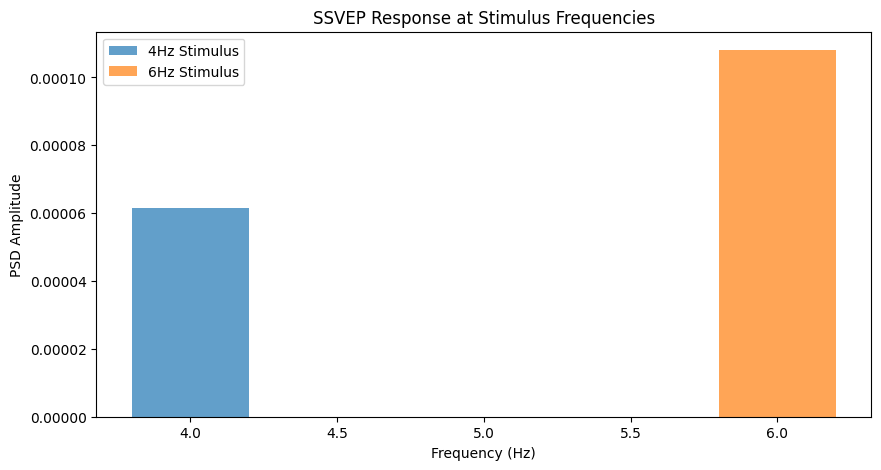

In [5]:
import matplotlib.pyplot as plt

def plot_ssvep_results(psd_results, freqs):
    """
    Plot the average PSD results for different SSVEP frequencies.

    Parameters:
        psd_results (dict): Dictionary with event names as keys and PSD results as values.
        freqs (dict): Dictionary where keys are event names and values are the corresponding frequencies.

    Returns:
        None
    """
    plt.figure(figsize=(10, 5))
    for event, freq_list in freqs.items():
        avg_psd = psd_results[event].mean(axis=1).mean(axis=0)
        plt.bar(freq_list, avg_psd, width=0.4, alpha=0.7, label=f'{event} Stimulus')
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD Amplitude')
    plt.title('SSVEP Response at Stimulus Frequencies')
    plt.legend()
    plt.show()

# Plot the results
plot_ssvep_results(psd_results, ssvep_freqs)

### 3. Preprocessing and Compute Forward/Inverse Models for EEG Source Localization

This section involves preprocessing EEG data, computing forward and inverse models, and estimating brain sources during SSVEP tasks. These steps ensure proper data preparation and signal localization for subsequent analysis. Functions are defined for modularity and readability.


1. Importing necessary libraries.
2. Preprocessing EEG data by:
   - Excluding non-EEG channels.
   - Renaming and verifying channels.
   - Setting the montage.
   - Handling missing channel locations.
3. Computing forward and inverse models:
   - Generating a BEM model and solution.
   - Setting up the source space.
   - Computing the forward and inverse solutions.
4. Applying the inverse solution to SSVEP epochs and visualizing source activations.
5. Saving the results for reproducibility.

Functions are defined for modularity and readability.

#### 3.1 Preprocessing EEG Data

Preprocessing involves cleaning and preparing the EEG data for source localization. Key steps include:
- **Excluding non-EEG channels** (e.g., GSR, EXG).
- **Renaming channels** to follow standardized naming conventions.
- **Setting the montage** to the 10-20 EEG system for spatial consistency.
- **Handling missing locations** by dropping channels with undefined electrode positions.
- **Recomputing average reference** to reduce baseline noise and improve signal clarity.

In [6]:
import os
import mne
import numpy as np
from mne.channels import make_standard_montage

def preprocess_eeg(raw, epochs):
    """
    Preprocess EEG data: set channel types, montage, and references.

    Parameters:
        raw (Raw): The raw EEG data.
        epochs (Epochs): The epochs of EEG data to process.
    
    Returns:
        raw (Raw): The processed raw EEG data.
        epochs (Epochs): The processed epochs.
    """
    # Exclude non-EEG channels
    non_eeg_channels = ['EXG1', 'EXG2', 'GSR1', 'GSR2']
    valid_mapping = {ch: 'misc' for ch in non_eeg_channels if ch in raw.info['ch_names']}
    if valid_mapping:
        raw.set_channel_types(valid_mapping)
        print("Non-EEG channels successfully set to 'misc'.")
    raw.pick('eeg')
    print("Non-EEG channels excluded successfully.")

    # Rename channels
    rename_channels(raw)

    # Set montage and handle missing channels
    set_montage_and_check_locs(raw)

    # Recompute average reference
    raw.set_eeg_reference('average', projection=True)
    raw.apply_proj()
    print("EEG average reference set and applied for raw.")
    epochs.set_eeg_reference('average', projection=True)
    epochs.apply_proj()
    print("EEG average reference set and applied for epochs.")
    return raw, epochs

def rename_channels(raw):
    """
    Rename EEG channels to avoid conflicts.

    Parameters:
        raw (Raw): The raw EEG data.
    
    Returns:
        None
    """
    mapping = {'AFp1': 'Fp1', 'AFp2': 'Fp2'}
    conflicting_channels = [
        new_name for new_name in mapping.values() if new_name in raw.info['ch_names']
    ]
    if conflicting_channels:
        print(f"Conflicting target channel names detected: {conflicting_channels}")
        mapping = {k: v for k, v in mapping.items() if v not in conflicting_channels}
    raw.rename_channels(mapping)
    print("Channels renamed successfully.")

def set_montage_and_check_locs(raw):
    """
    Set montage and handle missing EEG channel locations.

    Parameters:
        raw (Raw): The raw EEG data.

    Returns:
        None
    """
    montage = make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')
    print("Standard 10-20 EEG montage set successfully.")

    missing_locs = [
        ch_name for ch_name, ch in zip(raw.info['ch_names'], raw.info['chs'])
        if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and not np.any(ch['loc'][:3])
    ]
    if missing_locs:
        print(f"Warning: Missing locations for channels: {missing_locs}")
        raw.drop_channels(missing_locs)
        print(f"Dropped channels with missing locations: {missing_locs}")

raw, epochs = preprocess_eeg(raw, epochs)
epochs.save("results/epochs/OT-epo.fif", overwrite=True)

Non-EEG channels successfully set to 'misc'.
Non-EEG channels excluded successfully.
Conflicting target channel names detected: ['Fp1', 'Fp2']
Channels renamed successfully.
Standard 10-20 EEG montage set successfully.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated


/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_34252/3157260551.py:22: RuntimeWarning: The unit for channel(s) EXG1, EXG2, GSR1, GSR2 has changed from V to NA.
  raw.set_channel_types(valid_mapping)


SSP projectors applied...
EEG average reference set and applied for raw.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG average reference set and applied for epochs.
Overwriting existing file.
Overwriting existing file.


#### 3.2 Compute Forward Models

The forward solution is computed to **map electrical potentials from the brain to EEG electrodes**. This process involves:

- Creating a **Boundary Element Model (BEM)** for head geometry.
- Setting up the **source space** for potential brain activity.
- Verifying the **transformation matrix** for alignment between electrodes and the head model.

In [7]:
import os
import mne
import numpy as np
from mne.channels import make_standard_montage

def compute_bem_and_forward(subject, subjects_dir, raw):
    """
    Compute BEM model, source space, and forward solution.

    Parameters:
        subject (str): Subject ID.
        subjects_dir (str): Path to the FreeSurfer subjects directory.
        raw (Raw): The raw EEG data.

    Returns:
        fwd (Forward): The computed forward solution.
    """
    # Ensure output directory exists
    os.makedirs("results/forward_models", exist_ok=True)
    
    # Step 10: Remove Invalid Channels
    invalid_channels = [
        ch['ch_name']
        for ch in raw.info['chs']
        if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and np.isnan(ch['loc'][:3]).any()
    ]
    if invalid_channels:
        print(f"Invalid channels detected: {invalid_channels}")
        raw.drop_channels(invalid_channels)
        print(f"Dropped invalid channels: {invalid_channels}")

    # Set montage and drop channels with missing locations
    montage = make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')
    print("Montage set successfully.")
    
    missing_locs = [
        ch_name for ch_name, ch in zip(raw.info['ch_names'], raw.info['chs'])
        if ch['kind'] == mne.io.constants.FIFF.FIFFV_EEG_CH and not np.any(ch['loc'][:3])
    ]
    if missing_locs:
        print(f"Channels with missing locations: {missing_locs}")
        raw.drop_channels(missing_locs)
        print(f"Dropped {len(missing_locs)} channels with missing locations.")
    
    # BEM model and solution
    subjects_dir = os.path.expanduser(subjects_dir)
    bem_model_file = os.path.join(subjects_dir, subject, "bem", f"{subject}-bem-model.fif")
    bem_solution_file = os.path.join(subjects_dir, subject, "bem", f"{subject}-bem-sol.fif")
    src_file = os.path.join(subjects_dir, subject, "bem", f"{subject}-oct-6-src.fif")
    
    # Forward solution
    trans = f"{subjects_dir}/{subject}/bem/{subject}-trans.fif"
    if not os.path.exists(trans):
        raise FileNotFoundError(f"Transformation file {trans} not found. Ensure coregistration is complete.")
    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src_file, bem=bem_solution_file, eeg=True)
    
    # Save forward solution
    fwd_path = "results/forward_models/OT-fwd.fif"
    mne.write_forward_solution(fwd_path, fwd, overwrite=True)
    print(f"Forward solution saved successfully at {fwd_path}")
    
    return fwd


# Call the function and save the forward model
fwd = compute_bem_and_forward("OT", "~/freesurfer/7.4.1/subjects", raw)

Invalid channels detected: ['AFp1', 'AFF5h', 'AFF1h', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', 'FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'PPO9h', 'PPO5h', 'PPO1h', 'POO9h', 'POO1', 'I1', 'OI1h', 'AFp2', 'AFF2h', 'AFF6h', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h', 'CCP2h', 'CCP4h', 'CCP6h', 'TTP8h', 'CPP2h', 'CPP4h', 'CPP6h', 'TPP8h', 'PPO2h', 'PPO6h', 'PPO10h', 'POO2', 'POO10h', 'OI2h', 'I2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8', 'Erg1', 'Erg2', 'Resp', 'Plet', 'Temp']
Dropped invalid channels: ['AFp1', 'AFF5h', 'AFF1h', 'FFT9h', 'FFT7h', 'FFC5h', 'FFC3h', 'FFC1h', 'FTT9h', 'FTT7h', 'FCC5h', 'FCC3h', 'FCC1h', 'TTP7h', 'CCP5h', 'CCP3h', 'CCP1h', 'TPP7h', 'CPP5h', 'CPP3h', 'CPP1h', 'PPO9h', 'PPO5h', 'PPO1h', 'POO9h', 'POO1', 'I1', 'OI1h', 'AFp2', 'AFF2h', 'AFF6h', 'FFC2h', 'FFC4h', 'FFC6h', 'FFT8h', 'FFT10h', 'FCC2h', 'FCC4h', 'FCC6h', 'FTT8h', 'FTT10h

#### 3.3. Computing Inverse Operator

The inverse operator **maps EEG signals back to brain sources**, enabling the **localization** of neural activity.

In [8]:
def compute_inverse_operator(raw, fwd, epochs):
    """
    Compute inverse operator using forward solution and noise covariance.

    Parameters:
        raw (Raw): The raw EEG data.
        fwd (Forward): The forward solution.
        epochs (Epochs): The epochs of EEG data to process.

    Returns:
        inverse_operator (InverseOperator): The computed inverse operator.
    """
    noise_cov = mne.compute_covariance(epochs, tmax=0., method='auto')
    inverse_operator = mne.minimum_norm.make_inverse_operator(
        raw.info, fwd, noise_cov, loose=0.2, depth=0.8
    )
    print("Inverse operator created successfully.")
    return inverse_operator

inverse_operator = compute_inverse_operator(raw, fwd, epochs)

    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 143 -> 138
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 9064
log-likelihood on unseen data (descending order):
   empirical: -234.345
   shrunk: -234.385
   diagonal_fixed: -320.474
selecting best estimator: empirical
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 72 channels.
    72 out of 72 channels remain after picking
Selected 72 chann

#### 3.4. Applying Inverse Solutions

We estimate brain activity during the 4 Hz and 6 Hz stimuli and save the source estimates for later visualization.

In [9]:
def apply_inverse_solution(epochs, inverse_operator, subject, subjects_dir):
    """
    Apply inverse solution to epochs and save the results.

    Parameters:
        epochs (Epochs): The epochs to apply the inverse solution to.
        inverse_operator (InverseOperator): The inverse operator.
        subject (str): Subject ID.
        subjects_dir (str): Path to the FreeSurfer subjects directory.

    Returns:
        stc_4hz (SourceEstimate): Source estimate for the 4Hz condition.
        stc_6hz (SourceEstimate): Source estimate for the 6Hz condition.
    """
    # Ensure results directories exist
    os.makedirs("results/source_estimates", exist_ok=True)
    os.makedirs("results/activation_movies", exist_ok=True)
    os.makedirs("results/epochs", exist_ok=True)
    
    stc_4hz = mne.minimum_norm.apply_inverse(
        epochs['4Hz'].average(), inverse_operator, lambda2=1. / 9., method='dSPM'
    )
    stc_6hz = mne.minimum_norm.apply_inverse(
        epochs['6Hz'].average(), inverse_operator, lambda2=1. / 9., method='dSPM'
    )
    # Save source estimates
    stc_4hz.save('results/source_estimates/ssvep_4hz_source', overwrite=True)
    stc_6hz.save('results/source_estimates/ssvep_6hz_source', overwrite=True)
    print("Source estimates saved successfully.")
    return stc_4hz, stc_6hz

stc_4hz, stc_6hz = apply_inverse_solution(epochs, inverse_operator, "OT", "~/freesurfer/7.4.1/subjects")

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 40
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 71 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "4Hz"...
    Picked 72 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  44.1% variance
    Combining the current components...
    dSPM...
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 40
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 71 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "6H

#### 3.5 Set Up the Environment

Ensures the correct setup of the `SUBJECTS_DIR` environment variable for FreeSurfer, which is essential for accessing subject data and parcellations.

In [10]:
import os

def set_subjects_dir():
    """
    Ensure SUBJECTS_DIR is set.

    Returns:
        subjects_dir (str): Path to the FreeSurfer subjects directory.
    """
    subjects_dir = os.path.expanduser("~/freesurfer/7.4.1/subjects")
    os.environ["SUBJECTS_DIR"] = subjects_dir
    return subjects_dir

# Set subjects directory
subjects_dir = set_subjects_dir()

### 4. EEG Source Localization and Movie Generation

This section details the process of localizing EEG sources to specific brain regions and generating activation movies for two frequency bands (4 Hz and 6 Hz). These steps involve selecting a region of interest (ROI) from parcellation labels, visualizing source activations, and saving the results as MP4 movies (brain activations for the specified ROI over time).

#### Usage:
- Set your subject ID, parcellation name, and the region of interest (ROI) label.
- The script will list all available labels and ensure the appropriate label is used.
- Movies for 4Hz and 6Hz activation will be generated and saved as `4Hz_activation.mp4` 
  and `6Hz_activation.mp4`.

#### Dependencies:
- **MNE-Python**
- **FreeSurfer** (for the subject data and parcellation)
- **imageio** (for saving the movie)

#### 4.1 List Available Labels

Lists all available labels in the parcellation to allow the user to choose the appropriate ROI.

In [11]:
from mne import read_labels_from_annot

def list_available_labels(subject, parc, subjects_dir):
    """
    List all available labels in the annotation.

    Parameters:
        subject (str): Subject ID.
        parc (str): Parcellation type (e.g., 'aparc').
        subjects_dir (str): Path to the FreeSurfer subjects directory.

    Returns:
        labels (list): List of available labels in the parcellation.
    """
    labels = read_labels_from_annot(subject, parc=parc, subjects_dir=subjects_dir)
    print("Available labels:")
    for label in labels:
        print(label.name)
    return labels

subject = "OT"  # Replace with your subject ID
parc = "aparc"  # Parcellation type

# List available labels
labels = list_available_labels(subject, parc, subjects_dir)

Reading labels from parcellation...
   read 34 labels from /Users/michaelzhou/freesurfer/7.4.1/subjects/OT/label/lh.aparc.annot
   read 34 labels from /Users/michaelzhou/freesurfer/7.4.1/subjects/OT/label/rh.aparc.annot
Available labels:
bankssts-lh
bankssts-rh
caudalanteriorcingulate-lh
caudalanteriorcingulate-rh
caudalmiddlefrontal-lh
caudalmiddlefrontal-rh
cuneus-lh
cuneus-rh
entorhinal-lh
entorhinal-rh
frontalpole-lh
frontalpole-rh
fusiform-lh
fusiform-rh
inferiorparietal-lh
inferiorparietal-rh
inferiortemporal-lh
inferiortemporal-rh
insula-lh
insula-rh
isthmuscingulate-lh
isthmuscingulate-rh
lateraloccipital-lh
lateraloccipital-rh
lateralorbitofrontal-lh
lateralorbitofrontal-rh
lingual-lh
lingual-rh
medialorbitofrontal-lh
medialorbitofrontal-rh
middletemporal-lh
middletemporal-rh
paracentral-lh
paracentral-rh
parahippocampal-lh
parahippocampal-rh
parsopercularis-lh
parsopercularis-rh
parsorbitalis-lh
parsorbitalis-rh
parstriangularis-lh
parstriangularis-rh
pericalcarine-lh
perical

#### 4.2 Select the Region of Interest (ROI)

Selects the desired label corresponding to the ROI from the list of available labels. The label is used to restrict the source estimate computation to a specific brain region.

In [12]:
def get_roi_label(labels, label_name):
    """
    Retrieve the ROI label from the list of labels.

    Parameters:
        labels (list): List of available labels.
        label_name (str): Name of the label corresponding to the ROI.

    Returns:
        roi_label (Label): The label object for the specified ROI.
    """
    roi_label = [label for label in labels if label.name == label_name]
    if not roi_label:
        raise ValueError(f"Label '{label_name}' not found in the annotation.")
    return roi_label[0]  # Use the first match if found

# Define the label name for ROI
label_name = "lingual-lh"  # Replace with your region of interest
roi_label = get_roi_label(labels, label_name)

#### 4.3 Generate Activation Movies

Visualizes source activations for 4 Hz and 6 Hz stimuli in the specified ROI and saves the results as movies in MP4 format.

In [13]:
def plot_and_save_activation_movie(stc, roi_label, subject, subjects_dir, filename, time_dilation=10, framerate=24):
    """
    Plot the source estimate and save the activation as a movie.
    
    Parameters:
        stc: SourceEstimate object.
        roi_label: Label object representing the region of interest.
        subject: str, subject ID.
        subjects_dir: str, path to the SUBJECTS_DIR.
        filename: str, output movie filename.
        time_dilation: float, time dilation factor for the movie.
        framerate: int, frames per second for the movie.
    """
    # Plot and restrict source estimate to ROI
    stc.plot(subject=subject, subjects_dir=subjects_dir, time_viewer=False)
    roi_activations = stc.in_label(roi_label)  # Use the label object
    
    # Save the visualization as a movie
    brain = stc.plot(subject=subject, subjects_dir=subjects_dir, time_viewer=False)
    brain.save_movie(f"results/activation_movies/{filename}", time_dilation=time_dilation, framerate=framerate)
    print(f"Saved movie: {filename}")

# Plot and save 4Hz activation
plot_and_save_activation_movie(
    stc_4hz, roi_label, subject, subjects_dir, filename="4Hz_activation.mp4"
)

# Plot and save 6Hz activation
plot_and_save_activation_movie(
    stc_6hz, roi_label, subject, subjects_dir, filename="6Hz_activation.mp4"
)

Using pyvistaqt 3d backend.
Using control points [3.9921354  4.49723901 8.78319396]
Using control points [3.9921354  4.49723901 8.78319396]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 1550) to (1600, 1552) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved movie: 4Hz_activation.mp4
Using control points [4.31144847 4.81377283 7.74134993]
Using control points [4.31144847 4.81377283 7.74134993]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1600, 1550) to (1600, 1552) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved movie: 6Hz_activation.mp4


### 5. Ground Truth Center Of Mass (COM) Calculation from MRI Data.

In this section, we will calculate the **Center of Mass (COM)** for the lesion regions of interest (ROIs) from structural MRI data. The COM will serve as the ground truth for comparison against the EEG-derived COM results.

#### 5.1 Loading MRI Data and Masking

Here, we will load the MRI data (e.g., `OT_defaced.nii.gz`), segment it to extract the lesion region (if applicable), and calculate the COM.

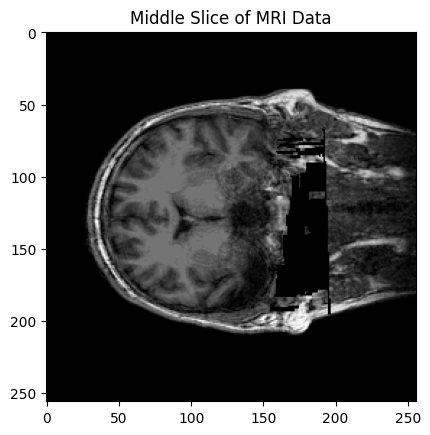

In [14]:
# 5.1 Load MRI Data for the Subject (OT)
import nibabel as nib

# Load the MRI scan (defaced)
mri_path = "datasets/MRI_dataset/OT_defaced.nii.gz"  # Adjust path
mri_img = nib.load(mri_path)

# Get the MRI data in array form
mri_data = mri_img.get_fdata()

# Optionally, visualize the MRI data (if necessary)
import matplotlib.pyplot as plt

plt.imshow(mri_data[:, :, mri_data.shape[2] // 2], cmap='gray')  # Show slice in the middle
plt.title('Middle Slice of MRI Data')
plt.show()

#### 5.2 Calculate COM for the Lesion Mask

This calculates the **Center of Mass (COM)** for the lesion mask derived from MRI data, which represents the **ground truth** spatial localization. The process is as follows:

1. **Visualize the MRI Slice**: Display a central slice of the MRI data to help visually identify the regions of interest.
2. **Print Basic Statistics**: Show statistical details such as the minimum, maximum, mean, median, and standard deviation of the intensity values in the MRI data.
3. **Thresholding**: Apply a threshold to create a binary lesion mask. The threshold is set to 50% of the maximum intensity value in the dataset, but this can be adjusted based on visual inspection and the nature of the data.
4. **Visualize the Lesion Mask**: Display the binary mask to confirm that the thresholding is working as expected.
5. **Calculate COM**: Use the `scipy.ndimage.center_of_mass` function to compute the center of mass of the lesion mask and print/save the results.

We begin by setting a threshold based on the intensity distribution in the MRI dataset, using a heuristic approach. The results will be saved in a text file (`results/com_results.txt`) for later analysis.

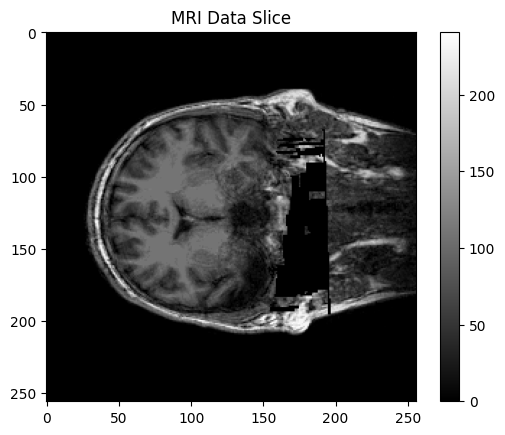

Min intensity: 0.0
Max intensity: 255.0
Mean intensity: 17.947287559509277
Median intensity: 0.0
Standard deviation: 37.022172374409195
Using threshold value: 127.5


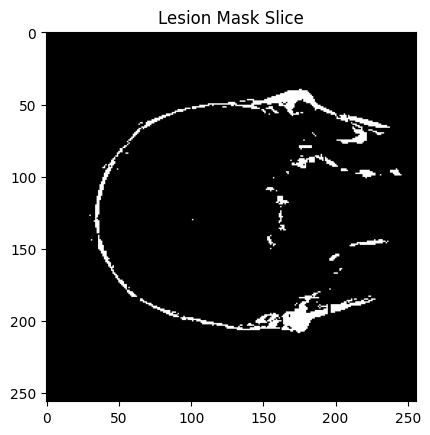

Ground Truth COM (x, y, z): (np.float64(125.4032271451539), np.float64(130.39120758185445), np.float64(98.96174028521102))
Center of Mass results saved successfully at results/com_results.txt


In [15]:
from scipy.ndimage import center_of_mass
import matplotlib.pyplot as plt
import numpy as np

# Load MRI data (assuming mri_data is already loaded)
plt.imshow(mri_data[:, :, mri_data.shape[2] // 2], cmap="gray")
plt.colorbar()
plt.title("MRI Data Slice")
plt.show()

# Print basic statistics
print(f"Min intensity: {mri_data.min()}")
print(f"Max intensity: {mri_data.max()}")
print(f"Mean intensity: {mri_data.mean()}")
print(f"Median intensity: {np.median(mri_data)}")
print(f"Standard deviation: {mri_data.std()}")

# Set a threshold (adjust based on intensity range)
threshold_value = 0.5 * max(mri_data.flatten())
print(f"Using threshold value: {threshold_value}")

# Create a binary mask for lesions
lesion_mask = mri_data > threshold_value

# Visualize the lesion mask
plt.imshow(lesion_mask[:, :, mri_data.shape[2] // 2], cmap="gray")
plt.title("Lesion Mask Slice")
plt.show()

# Save the MRI and lesion mask visualizations
plt.imshow(mri_data[:, :, mri_data.shape[2] // 2], cmap="gray")
plt.title("MRI Data Slice")
plt.savefig("results/mri_slice.png")  # Save MRI slice visualization
plt.close()

plt.imshow(lesion_mask[:, :, mri_data.shape[2] // 2], cmap="gray")
plt.title("Lesion Mask Slice")
plt.savefig("results/lesion_mask_slice.png")  # Save lesion mask visualization
plt.close()

# Compute COM for the lesion mask
ground_truth_com = center_of_mass(lesion_mask)
print(f"Ground Truth COM (x, y, z): {ground_truth_com}")

# Save the COM results in a text file
com_results_path = "results/com_results.txt"
with open(com_results_path, "w") as f:
    f.write(f"Ground Truth COM (x, y, z): {ground_truth_com}\n")

print(f"Center of Mass results saved successfully at {com_results_path}")

#### 5.3 EEG Source Localization COM Calculation

This section calculates the **Center of Mass (COM)** for the **EEG source estimates (4Hz and 6Hz)** in the **left and right hemispheres**. This represents the **EEG-based spatial localization**.

In [17]:
# Compute center of mass (COM) for the source estimates of 4Hz and 6Hz
com_4hz_left = stc_4hz.center_of_mass(hemi=0)  # Left hemisphere
com_4hz_right = stc_4hz.center_of_mass(hemi=1)  # Right hemisphere

com_6hz_left = stc_6hz.center_of_mass(hemi=0)  # Left hemisphere
com_6hz_right = stc_6hz.center_of_mass(hemi=1)  # Right hemisphere

print(f"Center of Mass for 4Hz (Left): {com_4hz_left}")
print(f"Center of Mass for 4Hz (Right): {com_4hz_right}")
print(f"Center of Mass for 6Hz (Left): {com_6hz_left}")
print(f"Center of Mass for 6Hz (Right): {com_6hz_right}")

# Save the COM results in a text file
com_results_path = "results/com_results.txt"
with open(com_results_path, "a") as f:  # Use "a" to append to the file
    f.write(f"Center of Mass for 4Hz (Left): {com_4hz_left}\n")
    f.write(f"Center of Mass for 4Hz (Right): {com_4hz_right}\n")
    f.write(f"Center of Mass for 6Hz (Left): {com_6hz_left}\n")
    f.write(f"Center of Mass for 6Hz (Right): {com_6hz_right}\n")

print(f"Center of Mass results saved successfully at {com_results_path}")

Center of Mass for 4Hz (Left): (np.int64(13180), 0, np.float64(0.742504767490186))
Center of Mass for 4Hz (Right): (np.int64(15111), 1, np.float64(0.742504767490186))
Center of Mass for 6Hz (Left): (np.int64(20617), 0, np.float64(0.7223668427268242))
Center of Mass for 6Hz (Right): (np.int64(13330), 1, np.float64(0.7223668427268242))
Center of Mass results saved successfully at results/com_results.txt


### 6. Center of Mass (COM) Distance Calculation

In this section, we calculate the distance between the **ground truth COM** derived from the MRI data and the **EEG-based COM** for the 4Hz and 6Hz frequency bands. These distances help assess the accuracy of the EEG-based COM predictions.

#### 6.1 Compute COM Distances

Calculate the distance between the ground truth COM (from MRI) and the EEG-derived COMs.

In [18]:
import numpy as np

# Compare these coordinates using the Euclidean distance
def compute_com_distance(com1, com2):
    return np.linalg.norm(np.array(com1) - np.array(com2))


# Compare with the 4Hz COM (Left and Right)
distance_4hz_left = compute_com_distance(ground_truth_com, com_4hz_left)
distance_4hz_right = compute_com_distance(ground_truth_com, com_4hz_right)

# Compare with the 6Hz COM (Left and Right)
distance_6hz_left = compute_com_distance(ground_truth_com, com_6hz_left)
distance_6hz_right = compute_com_distance(ground_truth_com, com_6hz_right)

# Output the distances
print(f"Distance between Ground Truth COM and 4Hz (Left) COM: {distance_4hz_left:.2f} mm")
print(f"Distance between Ground Truth COM and 4Hz (Right) COM: {distance_4hz_right:.2f} mm")
print(f"Distance between Ground Truth COM and 6Hz (Left) COM: {distance_6hz_left:.2f} mm")
print(f"Distance between Ground Truth COM and 6Hz (Right) COM: {distance_6hz_right:.2f} mm")

Distance between Ground Truth COM and 4Hz (Left) COM: 13055.62 mm
Distance between Ground Truth COM and 4Hz (Right) COM: 14986.48 mm
Distance between Ground Truth COM and 6Hz (Left) COM: 20492.25 mm
Distance between Ground Truth COM and 6Hz (Right) COM: 13205.60 mm


#### 6.2 Save COM Distance Results

Save the results of the COM distance comparison in a file for later use.

In [19]:
# Save the COM distances in a text file
com_distance_results_path = "results/com_distances.txt"
with open(com_distance_results_path, "w") as f:
    f.write(f"Distance between Ground Truth COM and 4Hz (Left) COM: {distance_4hz_left:.2f} mm\n")
    f.write(f"Distance between Ground Truth COM and 4Hz (Right) COM: {distance_4hz_right:.2f} mm\n")
    f.write(f"Distance between Ground Truth COM and 6Hz (Left) COM: {distance_6hz_left:.2f} mm\n")
    f.write(f"Distance between Ground Truth COM and 6Hz (Right) COM: {distance_6hz_right:.2f} mm\n")

print(f"COM distance results saved successfully at {com_distance_results_path}")

COM distance results saved successfully at results/com_distances.txt
